In [33]:
# Berkeley Graduate Admissions Analysis - Simpson's Paradox
# Uncovering Gender Bias Patterns in 1973 UC Berkeley Admissions Data

## 1. Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [34]:
#  Data Loading and Exploration
df = pd.read_csv('data/berkeley.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head(10))

print("\nDataset Info:")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())

print("\nValue Counts:")
print("\nMajor Distribution:")
print(df['Major'].value_counts())
print("\nSex Distribution:")
print(df['Sex'].value_counts())
print("\nAdmission Distribution:")
print(df['Admission'].value_counts())

# Data Preprocessing
# Binary encodings for modeling
df['Admitted'] = (df['Admission'] == 'Accepted').astype(int)  # 1 if Accepted, else 0
df['Gender'] = (df['Sex'] == 'M').astype(int)                # 1 for Male, 0 for Female

major_dummies = pd.get_dummies(df['Major'], prefix='Major')
df_encoded = pd.concat([df, major_dummies], axis=1)

print("\nEncoded Dataset Preview:")
print(df_encoded.head())

Dataset Shape: (12763, 4)

First few rows:
   Year  Major Sex Admission
0  1973      C   F  Rejected
1  1973      B   M  Accepted
2  1973  Other   F  Accepted
3  1973  Other   M  Accepted
4  1973  Other   M  Rejected
5  1973  Other   M  Rejected
6  1973      F   F  Accepted
7  1973  Other   M  Accepted
8  1973  Other   M  Rejected
9  1973      A   M  Accepted

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12763 entries, 0 to 12762
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Year       12763 non-null  int64 
 1   Major      12763 non-null  object
 2   Sex        12763 non-null  object
 3   Admission  12763 non-null  object
dtypes: int64(1), object(3)
memory usage: 399.0+ KB

Missing Values:
Year         0
Major        0
Sex          0
Admission    0
dtype: int64

Value Counts:

Major Distribution:
Major
Other    7924
A        1246
C         918
D         792
F         714
B         585
E         584


=== Overall Admission Rates by Gender ===
     Admitted  Total  Admission_Rate
Sex                                 
F        1494   4321        0.345753
M        3738   8442        0.442786


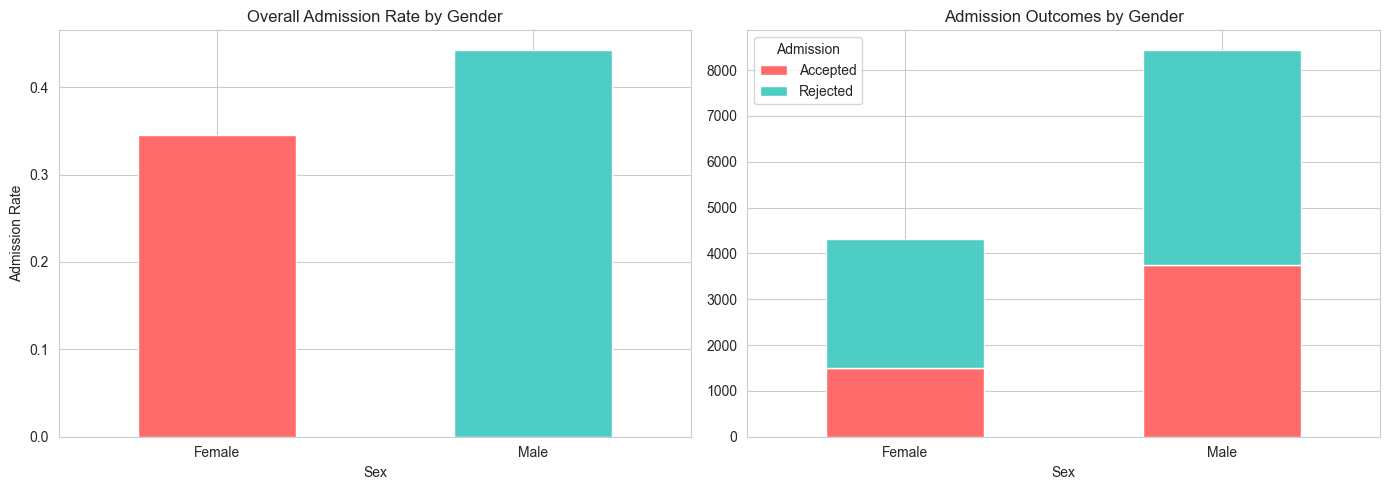


=== Admission Rates by Department and Gender ===
           Admitted  Total  Admission_Rate
Major Sex                                 
A     F          89    108        0.824074
      M         825   1138        0.724956
B     F          17     25        0.680000
      M         353    560        0.630357
C     F         201    593        0.338954
      M         120    325        0.369231
D     F         131    375        0.349333
      M         138    417        0.330935
E     F          94    393        0.239186
      M          53    191        0.277487
F     F          25    341        0.073314
      M          22    373        0.058981
Other F         937   2486        0.376911
      M        2227   5438        0.409526


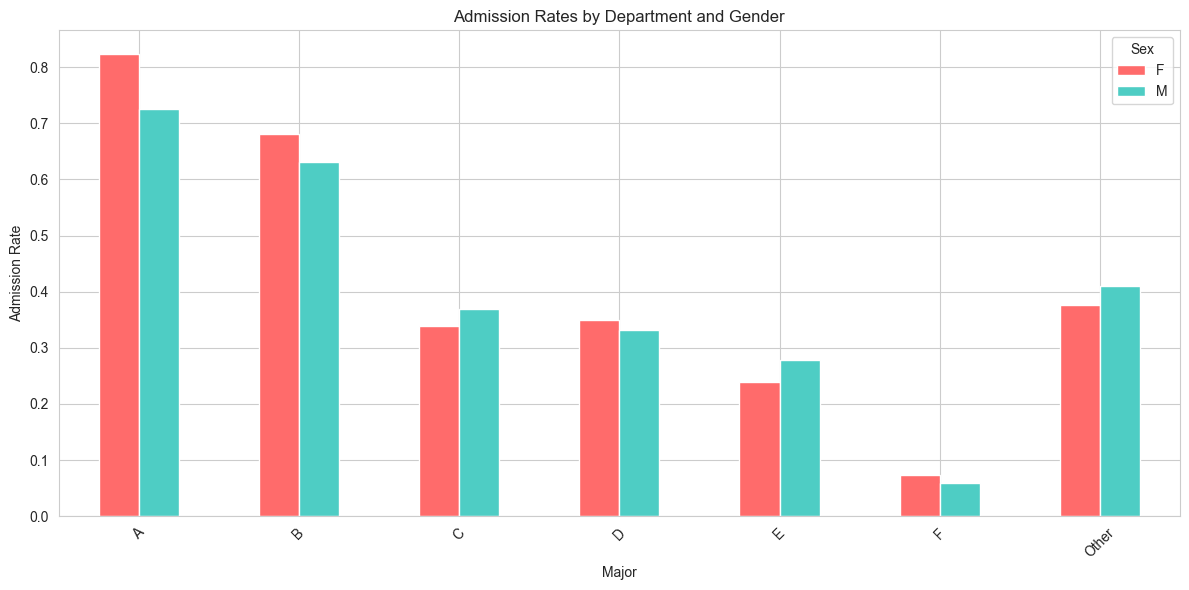


=== Application Volume by Department ===
Sex       F     M
Major            
A       108  1138
B        25   560
C       593   325
D       375   417
E       393   191
F       341   373
Other  2486  5438


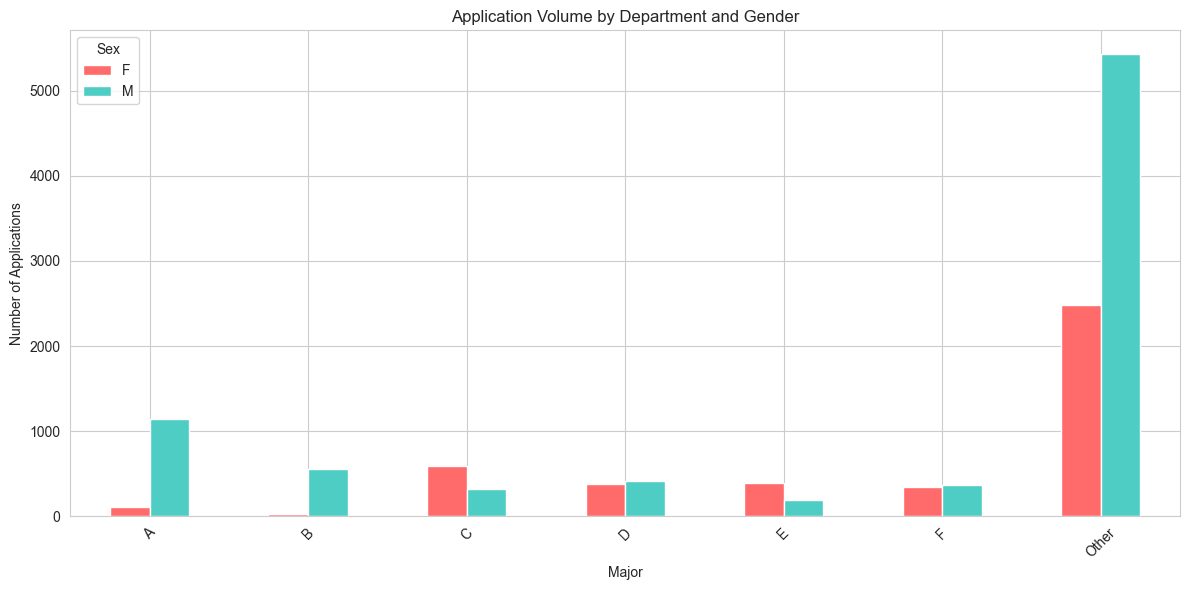

In [ ]:
## 1. Exploratory Analysis

# Overall Admission Rates by Gender
overall_stats = df.groupby('Sex')['Admitted'].agg(['sum', 'count', 'mean'])
overall_stats.columns = ['Admitted', 'Total', 'Admission_Rate']
print("\n=== Overall Admission Rates by Gender ===")
print(overall_stats)

# Visualization: Overall Rates & Admission Outcomes
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

overall_stats['Admission_Rate'].plot(kind='bar', ax=ax[0], color=['#FF6B6B', '#4ECDC4'])
ax[0].set_title('Overall Admission Rate by Gender')
ax[0].set_ylabel('Admission Rate')
ax[0].set_xticklabels(['Female', 'Male'], rotation=0)

sex_counts = df.groupby(['Sex', 'Admission']).size().unstack()
sex_counts.plot(kind='bar', stacked=True, ax=ax[1], color=['#FF6B6B', '#4ECDC4'])
ax[1].set_title('Admission Outcomes by Gender')
ax[1].set_xticklabels(['Female', 'Male'], rotation=0)

plt.tight_layout()
plt.savefig('outputs/figures/overall_rates_&_admission_outcomes.png', dpi=300, bbox_inches='tight')
plt.show()

# Admission Rates by Department and Gender
dept_gender_stats = df.groupby(['Major', 'Sex'])['Admitted'].agg(['sum', 'count', 'mean'])
dept_gender_stats.columns = ['Admitted', 'Total', 'Admission_Rate']
print("\n=== Admission Rates by Department and Gender ===")
print(dept_gender_stats)

dept_gender_pivot = df.pivot_table(values='Admitted', index='Major', columns='Sex', aggfunc='mean')

dept_gender_pivot.plot(kind='bar', figsize=(12, 6), color=['#FF6B6B', '#4ECDC4'])
plt.title('Admission Rates by Department and Gender')
plt.ylabel('Admission Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/figures/admission_rate_by_department.png', dpi=300, bbox_inches='tight')
plt.show()

# Application Volume by Department
dept_volume = df.groupby(['Major', 'Sex']).size().unstack()
print("\n=== Application Volume by Department ===")
print(dept_volume)

dept_volume.plot(kind='bar', figsize=(12, 6), color=['#FF6B6B', '#4ECDC4'])
plt.title('Application Volume by Department and Gender')
plt.ylabel('Number of Applications')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/figures/application_volume_by_department_gender.png', dpi=300, bbox_inches='tight')
plt.show()


In [36]:
## 2. Statistical Testing

# Overall Chi-Square Test
contingency_table = pd.crosstab(df['Sex'], df['Admission'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("\n=== Chi-Square Test: Overall Gender Bias ===")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Significant at α=0.05? {p_value < 0.05}")

# Chi-Square By Department
print("\n=== Chi-Square Tests by Department ===")
for major in df['Major'].unique():
    dept_data = df[df['Major'] == major]
    if len(dept_data['Sex'].unique()) > 1 and len(dept_data['Admission'].unique()) > 1:
        contingency = pd.crosstab(dept_data['Sex'], dept_data['Admission'])
        chi2, p_val, _, _ = stats.chi2_contingency(contingency)
        print(f"\n{major}:")
        print(f"  Chi-Square: {chi2:.4f}, P-value: {p_val:.4f}")
        print(f"  Significant: {p_val < 0.05}")



=== Chi-Square Test: Overall Gender Bias ===
Chi-Square Statistic: 110.8489
P-value: 0.0000
Significant at α=0.05? True

=== Chi-Square Tests by Department ===

C:
  Chi-Square: 0.7184, P-value: 0.3967
  Significant: False

B:
  Chi-Square: 0.0851, P-value: 0.7705
  Significant: False

Other:
  Chi-Square: 7.4307, P-value: 0.0064
  Significant: True

F:
  Chi-Square: 0.3848, P-value: 0.5350
  Significant: False

A:
  Chi-Square: 4.4638, P-value: 0.0346
  Significant: True

D:
  Chi-Square: 0.2216, P-value: 0.6378
  Significant: False

E:
  Chi-Square: 0.8080, P-value: 0.3687
  Significant: False


In [37]:
## 3. Logistic Regression

### Model 1: Gender Only
X_naive = df[['Gender']]
y = df['Admitted']

model_naive = LogisticRegression()
model_naive.fit(X_naive, y)

print("\n=== Model 1: Gender Only ===")
print(f"Gender Coefficient: {model_naive.coef_[0][0]:.4f}")
print(f"Odds Ratio (Male vs Female): {np.exp(model_naive.coef_[0][0]):.4f}")

y_pred_naive = model_naive.predict(X_naive)
print(classification_report(y, y_pred_naive))

### Model 2: Gender + Department Controls
feature_cols = ['Gender'] + [col for col in df_encoded.columns if col.startswith('Major_')]
X_full = df_encoded[feature_cols]

model_full = LogisticRegression(max_iter=1000)
model_full.fit(X_full, y)

print("\n=== Model 2: Gender + Department ===")
print(f"Gender Coefficient (Controlled): {model_full.coef_[0][0]:.4f}")
print(f"Odds Ratio: {np.exp(model_full.coef_[0][0]):.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model_full.coef_[0],
    'Odds_Ratio': np.exp(model_full.coef_[0])
}).sort_values('Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Comparison
print("\n=== Model Comparison ===")
print(f"Naive Accuracy: {model_naive.score(X_naive, y):.4f}")
print(f"Full Model Accuracy: {model_full.score(X_full, y):.4f}")



=== Model 1: Gender Only ===
Gender Coefficient: 0.4068
Odds Ratio (Male vs Female): 1.5020
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      7531
           1       0.00      0.00      0.00      5232

    accuracy                           0.59     12763
   macro avg       0.30      0.50      0.37     12763
weighted avg       0.35      0.59      0.44     12763


=== Model 2: Gender + Department ===
Gender Coefficient (Controlled): 0.0918
Odds Ratio: 1.0961

Feature Importance:
       Feature  Coefficient  Odds_Ratio
1      Major_A     1.454369    4.281781
2      Major_B     0.980463    2.665691
0       Gender     0.091770    1.096113
7  Major_Other     0.060656    1.062533
3      Major_C    -0.120504    0.886474
4      Major_D    -0.180921    0.834502
5      Major_E    -0.581872    0.558851
6      Major_F    -2.122011    0.119791

=== Model Comparison ===
Naive Accuracy: 0.5901
Full Model Accuracy: 0.6478


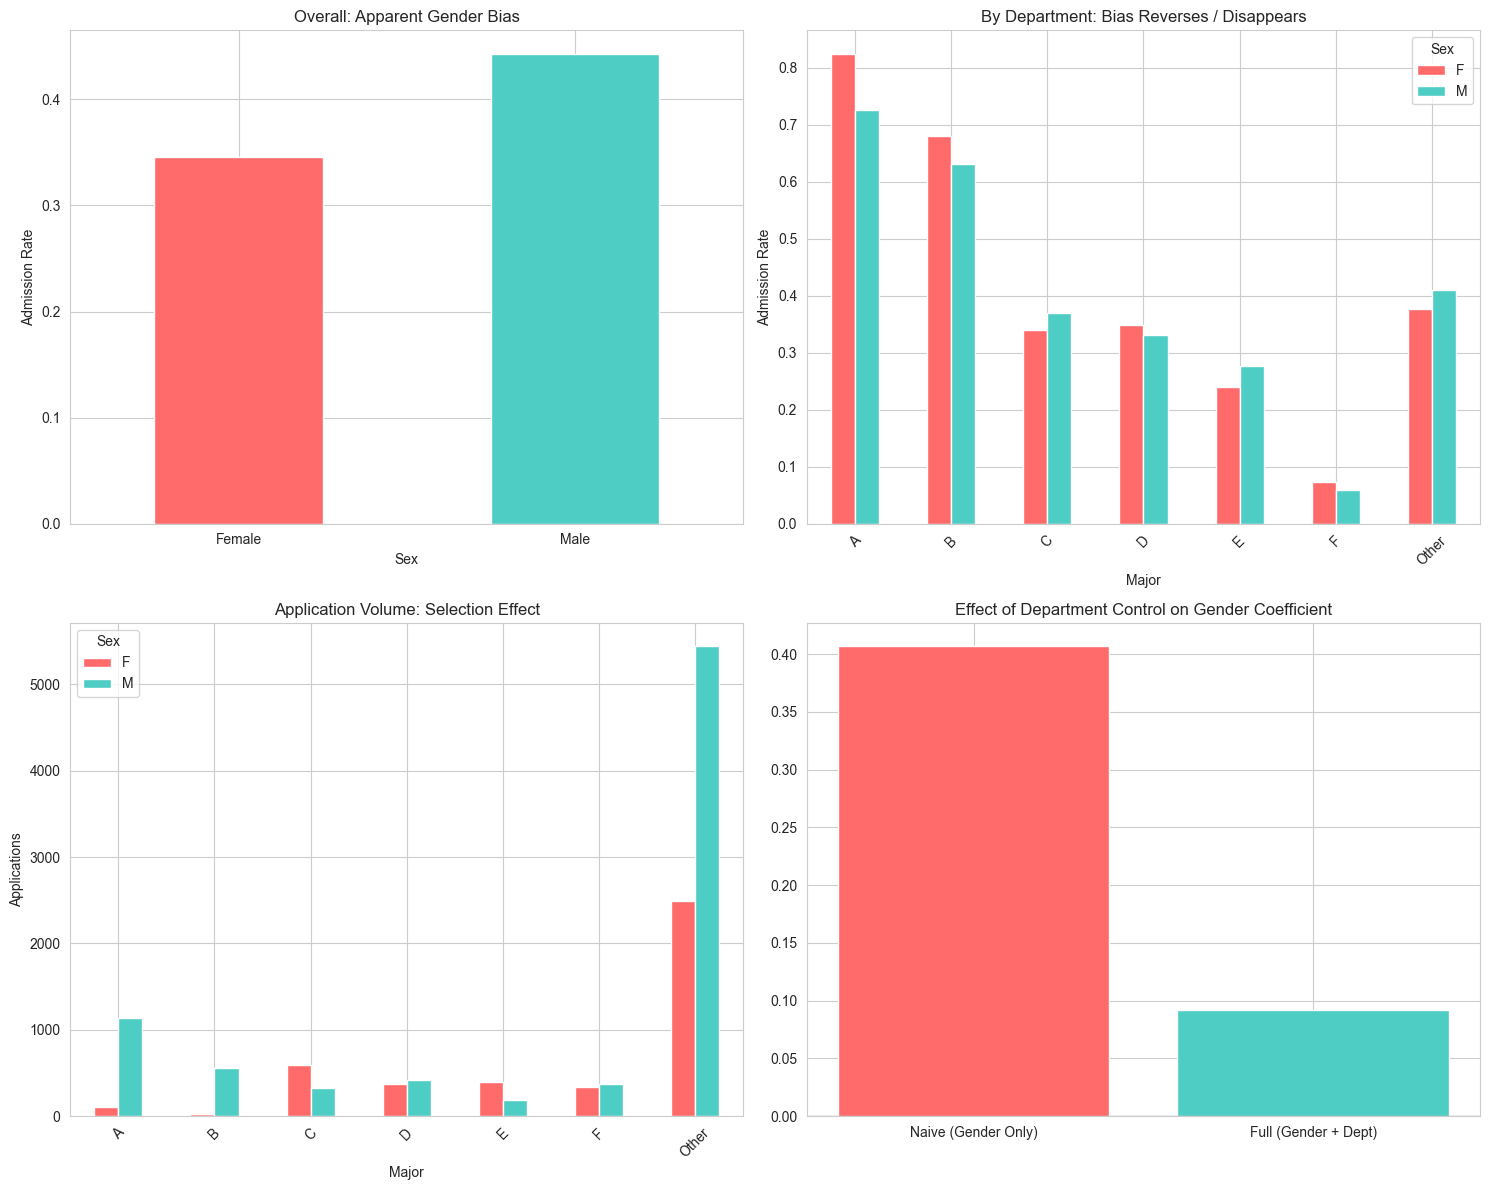

In [38]:
## 4. Simpson's Paradox Visualisation

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# (A) Overall Rates
ax1 = axes[0, 0]
overall_stats['Admission_Rate'].plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4'])
ax1.set_title("Overall: Apparent Gender Bias")
ax1.set_ylabel('Admission Rate')
ax1.set_xticklabels(['Female', 'Male'], rotation=0)

# (B) Department-Level Rates
ax2 = axes[0, 1]
dept_gender_pivot.plot(kind='bar', ax=ax2, color=['#FF6B6B', '#4ECDC4'])
ax2.set_title("By Department: Bias Reverses / Disappears")
ax2.set_ylabel('Admission Rate')
ax2.tick_params(axis='x', rotation=45)

# (C) Application Volume
ax3 = axes[1, 0]
dept_volume.plot(kind='bar', ax=ax3, color=['#FF6B6B', '#4ECDC4'])
ax3.set_title("Application Volume: Selection Effect")
ax3.set_ylabel('Applications')
ax3.tick_params(axis='x', rotation=45)

# (D) Model Coefficients Comparison
ax4 = axes[1, 1]
comparison = pd.DataFrame({
    'Model': ['Naive (Gender Only)', 'Full (Gender + Dept)'],
    'Coefficient': [model_naive.coef_[0][0], model_full.coef_[0][0]]
})

ax4.bar(comparison['Model'], comparison['Coefficient'], 
        color=['#FF6B6B', '#4ECDC4'])
ax4.axhline(y=0, color='black', linewidth=0.8)
ax4.set_title("Effect of Department Control on Gender Coefficient")

plt.tight_layout()
plt.savefig('outputs/figures/simpsons_paradox_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
